# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.


We generate a random secret floating number. Then we use hamming weight model to guess the number.

We develop a method of devide-and-conquer to quickly arrive to a close number with a defined precision.

## Guessing...

In [1]:
import numpy as np
import pandas as pd
import hashlib
from guess_range import *
from pprint import pprint

In [16]:
import binascii

def secret_signature(secret_numbers):
    m = hashlib.md5()
    m.update(secret_numbers)
    a = m.digest()
    s = 2
    n = [0] * s
    for idx in range(len(a)):
        i = idx % s
        n[i] = (n[i] + a[idx]) % 256
    return binascii.hexlify(bytes(n))        

In [3]:
def guess_number_range_stat(secret_number, guess_range, precision, known_input_size=1000):
    results = guess_number_range_subranges(secret_number, guess_range, precision, known_input_size)
    #
    # discard low correlation results
    corr_values = results[CORRELATION]
    results = results[corr_values > (corr_values.max() * 0.95)].sort_values(CORRELATION, ascending=False)
    guess_values = ((results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0).round(decimals=int(-np.log10(precision)))    
    return results[~guess_values.duplicated(keep='first')]

## Test single point

In [4]:
SECRET_VALUE = 'secret value'

guess_range = (0, 5.0)
precision = 1e-6
#
# initalize parameter and generate a random number (secret number)
exponent= -1
known_input_size = 1000
known_inputs = np.random.uniform(-10 ** (-exponent + 1), 10 ** (-exponent + 1), known_input_size)
guess_subrange = (0.0, 0.5 * (10 ** exponent))

In [5]:
# secret_number = random.uniform(guess_range[0] / 10, guess_range[1] / 10)
secret_number = 0.1931 * (10 ** exponent)
#secret_number = np.round(secret_number, int(-np.log10(precision)))
print('secret_number = %.08f' % secret_number)
number_of_guess_values = 500

secret_number = 0.01931000


In [52]:
%%time
df = guess_number_range(secret_hw, guess_range, precision, known_inputs, number_values=500)
df

-0.9949120506434259 0.9991980831032485


(1.4652466773986816, 1.4652472734451294, 0.13442619417908802)

In [53]:
%%time
secret_hw=np.vectorize(hamming_weight)(known_inputs * secret_number)
single_correlations = compute_corr(secret_hw=secret_hw, known_inputs=known_inputs,
                                   guess_range=guess_subrange, number_values=number_of_guess_values)
single_correlations.sort_values(ascending=False, inplace=True)
single_correlations.iloc[:10]

(0.0, 5.0)


0.950115    0.405784
0.949749    0.383485
0.475135    0.352044
0.475274    0.299008
1.904768    0.288042
1.892493    0.287744
1.896176    0.285569
1.891378    0.284225
1.893414    0.273399
1.890688    0.263431
dtype: float64

In [66]:
ax = single_correlations.sort_index().plot(figsize=(15, 6), label='HW correlations')
ax.vlines(secret_number, 
          single_correlations.min(),
          single_correlations.max(),
          color='red', label='secret value')
ax.legend()
ax.grid()

NameError: name 'single_correlations' is not defined

In [55]:
%%time
TEST_VALUE = 'test value'
low_range, high_range = guess_range

results = pd.DataFrame()

for (low_range, high_range) in get_subranges(guess_range, precision):
    pprint('searching in the range %f - %f' % (low_range, high_range))
    exponent = np.floor(-np.log10(np.max(np.abs(np.asarray([low_range, high_range])))))
    for e in [exponent-1, exponent, exponent+1]:
        known_inputs = np.random.uniform(-10 ** e, 10 ** e, known_input_size)
        print(e, known_inputs.min(), known_inputs.max())
        secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

        corr = compute_corr(secret_hw=secret_hw, known_inputs=known_inputs,
                                           guess_range=(low_range, high_range), number_values=number_of_guess_values)
        df = pd.DataFrame([corr.index, corr.values], index=[TEST_VALUE, CORRELATION])
        df.loc[INPUT_ID] = e
        df.loc[LOW_VALUE] = low_range
        df.loc[HIGH_VALUE] = high_range
        results = pd.concat([results, df], axis=1, ignore_index=True)

'searching in the range 0.000000 - 5.000000'
-2.0 -0.009949059048927202 0.009969537086464987
-1.0 -0.09954367043693926 0.09976587901190823
0.0 -0.9988826611138091 0.9921828231067742
'searching in the range 0.000000 - 1.000000'
-1.0 -0.09983773972532624 0.09998552552994586
-0.0 -0.9990107630946168 0.9985745134606319
1.0 -9.988549348806643 9.974940101447448
'searching in the range 0.000000 - 0.100000'
0.0 -0.9968394337605309 0.9976147818115642
1.0 -9.998516793826633 9.966185881070576
2.0 -99.83213012450993 99.53188674780344
'searching in the range 0.000000 - 0.010000'
1.0 -9.974266940303327 9.987552617984896
2.0 -99.90322153509365 99.60707201451214
3.0 -998.4562318684922 997.6449153766193
'searching in the range 0.000000 - 0.001000'
2.0 -99.86679353801287 99.66241934630725
3.0 -998.9634598971351 992.0660209842467
4.0 -9992.23304189785 9999.7535021949
'searching in the range 0.000000 - 0.000100'
3.0 -999.5793535786421 998.3044899979793
4.0 -9990.909665554576 9984.859657788562
5.0 -99882.2

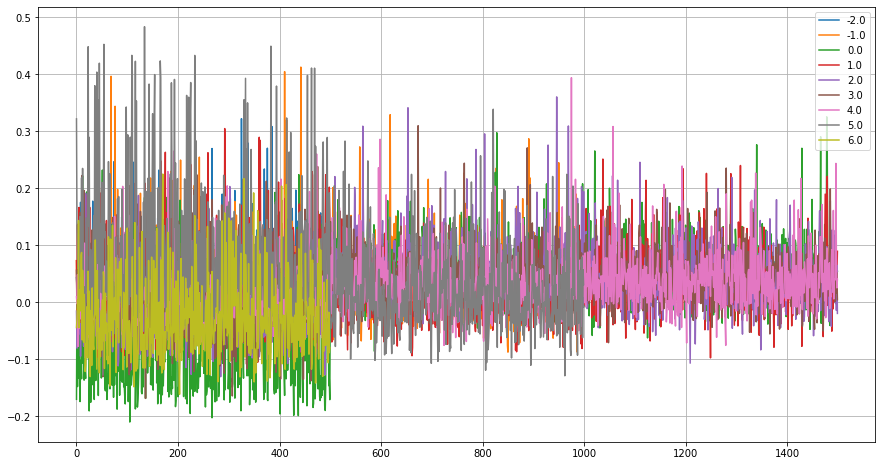

In [56]:
a = results.T
for idx, df in a.groupby(INPUT_ID):
    d = df[CORRELATION].reset_index(drop=True)
    ax = d.plot(figsize=(15,8), label=idx)
    ax.legend()
    ax.grid()

In [57]:
a = results.T
a.sort_values(CORRELATION, ascending=False)[:10]

,test value,correlation,input id,low value,high value
8634,0.000029,0.483528,5.0,0.0,0.0001
8554,0.000029,0.452539,5.0,0.0,0.0001
8883,0.000029,0.449343,5.0,0.0,0.0001
8523,0.000029,0.448370,5.0,0.0,0.0001
8609,0.000029,0.433261,5.0,0.0,0.0001
8733,0.000030,0.433147,5.0,0.0,0.0001
8665,0.000028,0.423469,5.0,0.0,0.0001
8616,0.000028,0.422859,5.0,0.0,0.0001
8545,0.000028,0.419519,5.0,0.0,0.0001
942,0.475060,0.412646,-1.0,0.0,5.0000


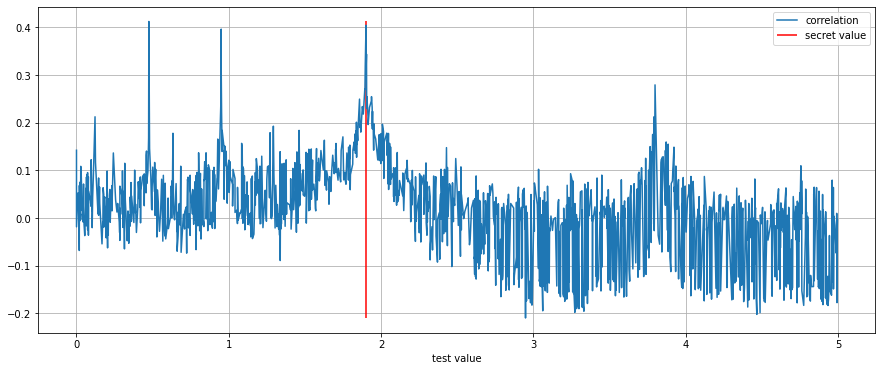

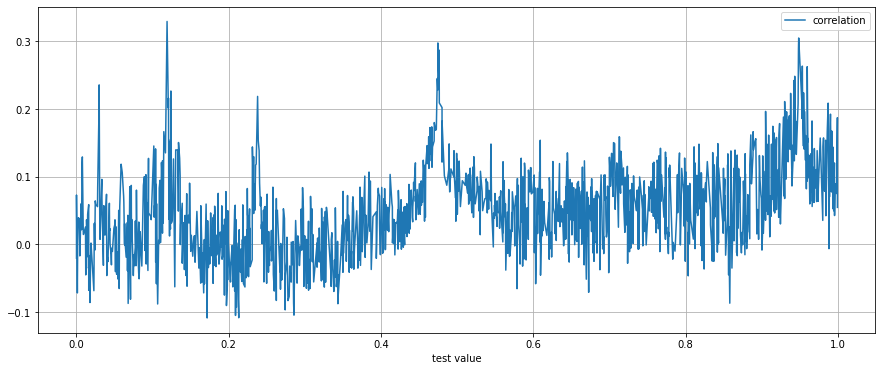

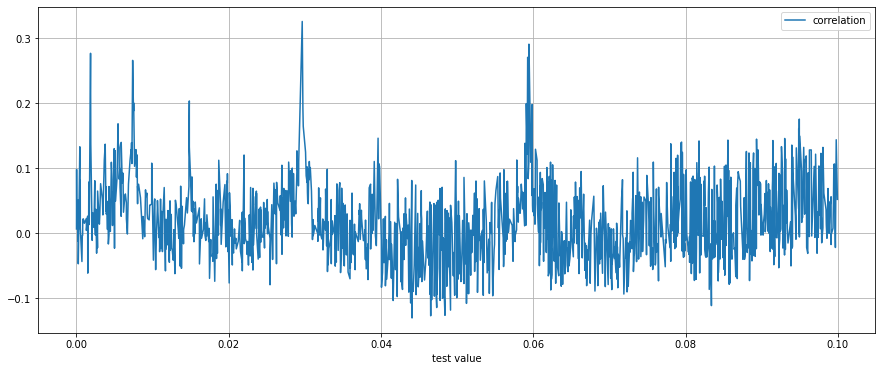

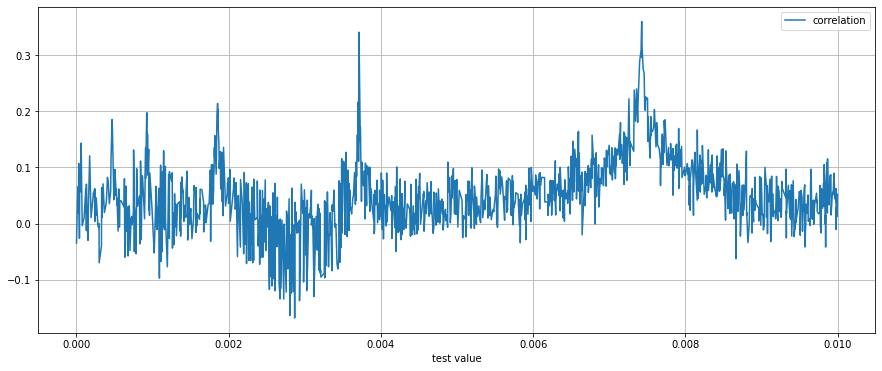

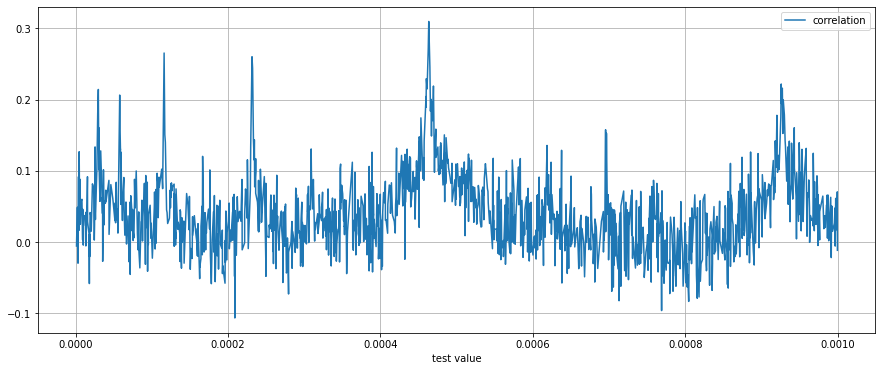

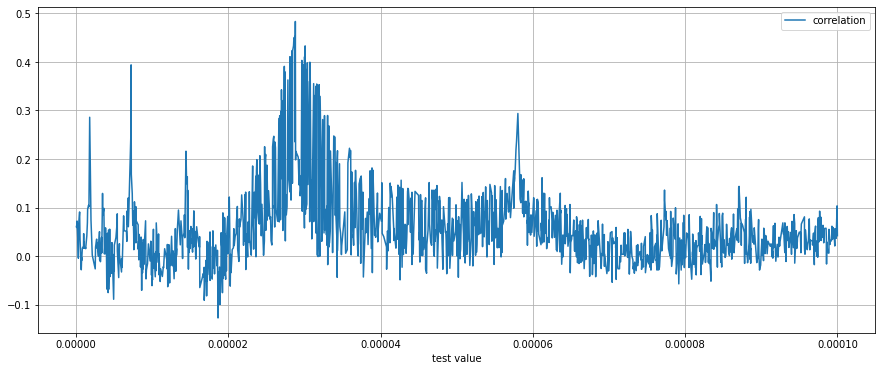

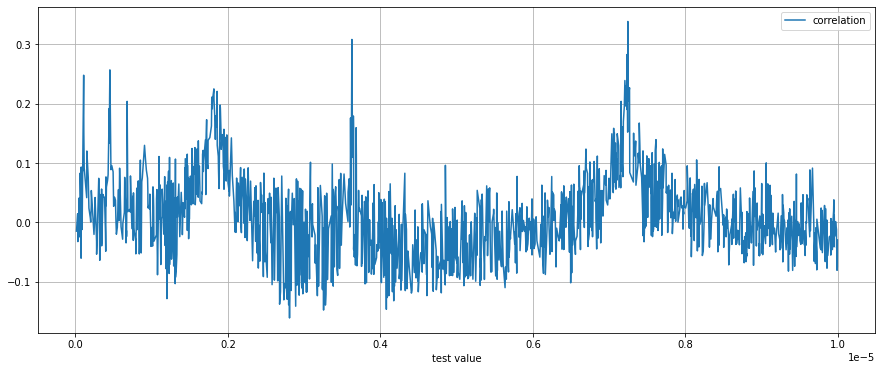

In [58]:
a = results.T
for g in a[HIGH_VALUE].unique():
    b = a[a[HIGH_VALUE] == g]
    c = b[[TEST_VALUE, CORRELATION]].set_index(TEST_VALUE).sort_index()
    ax = c.plot(figsize=(15,6))
    if secret_number <= g:
        ax.vlines(secret_number, 
                  c.min(),
                  c.max(),
                  color='red', label='secret value')
    ax.legend()
    ax.grid()

### Run advanced search

In [6]:
%%time

print('secret_number = %f' % secret_number)
print('guess_range = %s' % str(guess_range))
results = advanced_guess_number_range(secret_number, guess_range, precision, 
                                      known_input_size, number_of_guess_values)

secret_number = 0.019310
guess_range = (0, 5.0)
low value            1.235840
high value           1.235840
correlation          0.907259
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.943359
high value           4.943360
correlation          0.997858
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.943359
high value           4.943360
correlation          0.852031
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.617920
high value           0.617921
correlation          0.934264
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.077240
high value           0.077241
correlation          0.925643
input id            -0.000000
low search range     0.000000
high search range    1

In [7]:
results.sort_values(CORRELATION, ascending=False)

,low value,high value,correlation,input id,low search range,high search range
1,4.943359e+00,4.943360e+00,0.997858,-1.0,0.0,5.00000
14,7.542896e-05,7.542992e-05,0.989692,4.0,0.0,0.00100
7,1.931000e-02,1.931009e-02,0.988802,1.0,0.0,0.10000
10,4.827499e-03,4.827509e-03,0.984331,2.0,0.0,0.01000
16,7.542963e-05,7.542973e-05,0.976298,4.0,0.0,0.00010
8,9.654999e-03,9.655094e-03,0.963216,2.0,0.0,0.10000
9,4.827499e-03,4.827509e-03,0.959437,1.0,0.0,0.01000
5,7.723999e-02,7.724094e-02,0.943363,1.0,0.0,1.00000
12,6.034374e-04,6.034384e-04,0.934304,2.0,0.0,0.00100
3,6.179199e-01,6.179209e-01,0.934264,-1.0,0.0,1.00000


In [61]:
%%time
single_results = guess_number_range_stat(secret_number, guess_range, precision, known_input_size)

NameError: name 'guess_number_range_subranges' is not defined

In [ ]:
single_results.sort_values(CORRELATION, ascending=False)

In [ ]:
guess_values = (single_results[LOW_VALUE] + single_results[HIGH_VALUE]) / 2.0
error_rates = ((guess_values - secret_number) / secret_number).abs() * 100.0
pprint(error_rates)
guessed_number = guess_values[error_rates.idxmin()]    
pprint('the secret number = %f' % secret_number)
pprint('the guessed number = %f' % guessed_number)
pprint('best correlation = %f' % single_results[CORRELATION][error_rates.idxmin()])
pprint('error rate = %0.6f%s' % (error_rates.min(), '%'))

In [14]:
known_inputs = np.random.uniform(-1e2, 1e2, 1000)
secret_hw = pd.Series(np.vectorize(hamming_weight)(known_inputs * secret_number))
print('guess_range = %s' % str(guess_range))
guess_number_range(secret_hw, guess_range, precision, known_inputs)

guess_range = (0, 5.0)


TypeError: 'tuple' object is not callable

## Test multiple points

In [12]:
multiple_results = pd.DataFrame()

In [13]:
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (100,)


In [14]:
%%time
loops = 0
for idx in secret_numbers:
    # if the number is already treated, the ignore it
    if (SECRET_VALUE in multiple_results.columns) and (idx in multiple_results[SECRET_VALUE].values):
        continue

    print('secret_number = %f' % idx)
    print('guess_range = %s' % str(guess_range))
    results = advanced_guess_number_range(idx, guess_range, precision,
                                          known_input_size, number_of_guess_values)
    results[SECRET_VALUE] = idx
    pprint('=' * 20)
    pprint(results)
    guess_values = (results[LOW_VALUE] + results[HIGH_VALUE]) / 2.0
    multiple_results = pd.concat([multiple_results, results], axis=0, ignore_index=True)
    loops = loops + 1

secret_number = 1.199711
guess_range = (0, 5.0)
low value            4.798843
high value           4.798843
correlation          0.930076
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.798843
high value           4.798843
correlation          0.979070
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.199710
high value           1.199711
correlation          0.999836
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.599854
high value           0.599855
correlation          0.941646
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.599854
high value           0.599855
correlation          0.964659
input id            -0.000000
low search range     0.000000
high search range    1

low value            0.004426
high value           0.004426
correlation          0.900370
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.008852
high value           0.008852
correlation          0.960099
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004426
high value           0.004426
correlation          0.651728
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000017
high value           0.000017
correlation          0.946226
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000553
high value           0.000553
correlation          0.948862
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000009
high value           0.000009
correlation          0.955415
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.940872
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.730422
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    4.848955    4.848956     0.999596      -2.0               0.0   
1    4.848955    4.848956     0.999920      -1.0               0.0   
2    4.848955    4.848956     1.000000       0.0               0.0   
3    0.303060    0.303061     0.982673      -1.0               0.0   
4    0.303060    0.303061     0.738538    

low value            2.272346
high value           2.272347
correlation          0.997689
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.272346
high value           2.272347
correlation          0.999922
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.272346
high value           2.272347
correlation          0.999957
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.568087
high value           0.568088
correlation          0.956027
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.142021
high value           0.142022
correlation          0.879405
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.14

low value            0.030360
high value           0.030360
correlation          0.766567
input id             2.000000
low search range     0.000000
high search range    0.100000
dtype: float64
low value            0.001897
high value           0.001897
correlation          0.862781
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.001897
high value           0.001897
correlation          0.881514
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000949
high value           0.000949
correlation          0.956454
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000474
high value           0.000474
correlation          0.885083
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000025
high value           0.000025
correlation          0.747770
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            2.481461e-08
high value           2.482414e-08
correlation          8.422186e-01
input id             4.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.947212
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000006
high value           0.000006
correlation          0.914821
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   1.665447e+00  1.665447e+00     0.932782      -2.0               0.0   
1   8.327234e-01  8.327

low value            4.443373
high value           4.443374
correlation          0.938550
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.221686
high value           2.221687
correlation          0.962329
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.221686
high value           2.221687
correlation          0.842068
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.017357
high value           0.017358
correlation          0.800995
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.555421
high value           0.555422
correlation          0.997807
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.55

low value            0.000364
high value           0.000364
correlation          0.929065
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.001457
high value           0.001457
correlation          0.744130
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.001457
high value           0.001457
correlation          0.897962
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000364
high value           0.000364
correlation          0.867253
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000182
high value           0.000182
correlation          0.872756
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000003
high value           0.000003
correlation          0.980181
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.935305
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.935903
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    2.883062    2.883062     0.982087      -2.0               0.0   
1    2.883062    2.883062     0.982235      -1.0               0.0   
2    0.011262    0.011262     0.927255       0.0               0.0   
3    0.180191    0.180192     0.999857      -1.0               0.0   
4    0.720765    0.720766     0.976179    

low value            1.493478
high value           1.493479
correlation          0.998295
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.986957
high value           2.986958
correlation          0.924487
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.493478
high value           1.493479
correlation          0.997901
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.373369
high value           0.373370
correlation          0.958295
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.373369
high value           0.373370
correlation          0.978803
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.99

low value            0.003775
high value           0.003775
correlation          0.873250
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.007549
high value           0.007549
correlation          0.961131
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000472
high value           0.000472
correlation          0.908499
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000944
high value           0.000944
correlation          0.984318
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000472
high value           0.000472
correlation          0.943832
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000015
high value           0.000015
correlation          0.997450
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.863846
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            9.066963e-07
high value           9.067059e-07
correlation          9.902581e-01
input id             5.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.897074
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   9.507477e-01  9.507483e-01     0.998941      -2.0               0.0   
1   4.753739e-01  4.753

low value            0.871048
high value           0.871049
correlation          0.999927
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.484193
high value           3.484194
correlation          0.975325
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.435524
high value           0.435525
correlation          0.960491
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.871048
high value           0.871049
correlation          0.995628
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.871048
high value           0.871049
correlation          0.999580
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.87

low value            0.009131
high value           0.009131
correlation          0.735904
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004565
high value           0.004565
correlation          0.981060
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004565
high value           0.004565
correlation          0.848273
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000571
high value           0.000571
correlation          0.922631
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000571
high value           0.000571
correlation          0.884527
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000005
high value           0.000005
correlation          0.942567
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.976055
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.702343
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    2.826548    2.826549     0.940989      -2.0               0.0   
1    0.706637    0.706638     0.998079      -1.0               0.0   
2    1.413274    1.413274     0.963834       0.0               0.0   
3    0.706636    0.706637     0.997823      -1.0               0.0   
4    0.706636    0.706637     0.989913    

low value            1.858214
high value           1.858214
correlation          0.978263
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.116138
high value           0.116138
correlation          0.992760
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.858214
high value           1.858214
correlation          0.994775
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.116138
high value           0.116138
correlation          0.993512
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.929107
high value           0.929108
correlation          0.957787
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.23

low value            0.001220
high value           0.001220
correlation          0.921268
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004881
high value           0.004881
correlation          0.976618
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.001220
high value           0.001220
correlation          0.989768
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000076
high value           0.000076
correlation          0.997806
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.883201
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000062
high value           0.000062
correlation          0.924373
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            9.714508e-07
high value           9.714603e-07
correlation          9.381795e-01
input id             4.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000004
high value           0.000004
correlation          0.941982
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000004
high value           0.000004
correlation          0.742532
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   4.074585e+00  4.074585e+00     0.998659      -2.0               0.0   
1   4.074585e+00  4.074

low value            4.330482
high value           4.330482
correlation          0.911392
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.541310
high value           0.541310
correlation          0.957721
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.165241
high value           2.165241
correlation          1.000000
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.135327
high value           0.135328
correlation          0.975147
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.541309
high value           0.541310
correlation          0.856854
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.54

low value            0.000918
high value           0.000918
correlation          0.885806
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.003674
high value           0.003674
correlation          0.962372
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.003674
high value           0.003674
correlation          0.641318
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000230
high value           0.000230
correlation          0.937245
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000918
high value           0.000918
correlation          0.985173
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000009
high value           0.000009
correlation          0.999572
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000009
high value           0.000009
correlation          0.999145
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000009
high value           0.000009
correlation          0.931557
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    0.302403    0.302404     0.952101      -2.0               0.0   
1    4.838452    4.838453     0.943115      -1.0               0.0   
2    2.419226    2.419227     0.775079       0.0               0.0   
3    0.604806    0.604807     0.997636      -1.0               0.0   
4    0.604806    0.604807     0.998952    

low value            2.333459
high value           2.333459
correlation          0.981513
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.666917
high value           4.666918
correlation          0.864337
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.333459
high value           2.333459
correlation          0.876898
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.145841
high value           0.145842
correlation          0.983310
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.291682
high value           0.291683
correlation          0.916895
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.14

low value            0.009796
high value           0.009796
correlation          0.915190
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.009796
high value           0.009796
correlation          0.988112
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.009796
high value           0.009796
correlation          0.870376
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000612
high value           0.000612
correlation          0.974433
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000612
high value           0.000612
correlation          0.984528
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000066
high value           0.000066
correlation          0.911612
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000008
high value           0.000008
correlation          0.953542
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000008
high value           0.000008
correlation          0.852444
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000008
high value           0.000008
correlation          0.695679
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    4.314664    4.314665     0.999920      -2.0               0.0   
1    4.314664    4.314665     1.000000      -1.0         

low value            3.632147
high value           3.632148
correlation          0.987643
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.632147
high value           3.632148
correlation          0.982136
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.632147
high value           3.632148
correlation          0.757782
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.227009
high value           0.227010
correlation          0.988771
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.227009
high value           0.227010
correlation          0.999836
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.22

low value            0.002227
high value           0.002227
correlation          0.926487
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.008910
high value           0.008910
correlation          0.818967
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.001114
high value           0.001114
correlation          0.953690
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000557
high value           0.000557
correlation          0.894149
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000278
high value           0.000278
correlation          0.907281
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            5.516052e-08
high value           5.517006e-08
correlation          8.202598e-01
input id             4.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000007
high value           0.000007
correlation          0.948858
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000004
high value           0.000004
correlation          0.937558
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   3.702157e+00  3.702158e+00     0.987510      -2.0               0.0   
1   3.702157e+00  3.702158e+00     0.983230      -1.0               0.0   
2   2.313846e-01  2.313852e-01     0.999769       0.0               0.0   
3   4.627695e-01  4.627705e-01     0.917424      -1.0               

low value            1.218298
high value           1.218299
correlation          1.000000
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.436597
high value           2.436597
correlation          0.925156
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.436597
high value           2.436597
correlation          0.674144
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.076143
high value           0.076144
correlation          0.966462
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.076143
high value           0.076144
correlation          0.984432
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.60

low value            0.002528
high value           0.002528
correlation          0.830918
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.005055
high value           0.005055
correlation          0.877806
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.002528
high value           0.002528
correlation          0.901978
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000632
high value           0.000632
correlation          0.926583
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000632
high value           0.000632
correlation          0.955728
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000010
high value           0.000010
correlation          0.855534
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.979534
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            3.001595e-07
high value           3.001690e-07
correlation          9.289865e-01
input id             6.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   1.258990e+00  1.258990e+00     0.975576      -2.0               0.0   
1   1.258990e+00  1.258990e+00     0.994917      -1.0               0.0   
2   1.258990e+00  1.258990e+00     0.992161       0.0               0.0   
3   3.147469e-01  3.147478e-01     0.949599      -1.0               

low value            4.279156
high value           4.279156
correlation          0.933863
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.534894
high value           0.534895
correlation          0.948371
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.534894
high value           0.534895
correlation          0.958728
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.534894
high value           0.534895
correlation          0.948172
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.534894
high value           0.534895
correlation          0.958118
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.95

low value            0.001301
high value           0.001301
correlation          0.877450
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000020
high value           0.000020
correlation          0.655471
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000081
high value           0.000081
correlation          0.759882
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000651
high value           0.000651
correlation          0.877691
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000325
high value           0.000325
correlation          0.952041
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000005
high value           0.000005
correlation          0.985210
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.993763
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.939606
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    4.781458    4.781459     0.989152      -2.0               0.0   
1    4.781458    4.781459     0.983513      -1.0               0.0   
2    4.781458    4.781459     0.767269       0.0               0.0   
3    0.298841    0.298841     0.999402      -1.0               0.0   
4    0.149420    0.149421     0.917811    

low value            4.102823
high value           4.102823
correlation          0.999924
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.102823
high value           4.102823
correlation          0.999921
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.102823
high value           4.102823
correlation          0.999965
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.256426
high value           0.256427
correlation          0.972054
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.016026
high value           0.016027
correlation          0.749382
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.25

low value            0.020921
high value           0.020922
correlation          0.786170
input id             2.000000
low search range     0.000000
high search range    0.100000
dtype: float64
low value            0.002615
high value           0.002615
correlation          0.835795
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.002615
high value           0.002615
correlation          0.944422
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.002615
high value           0.002615
correlation          0.907473
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000654
high value           0.000654
correlation          0.938271
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000005
high value           0.000005
correlation          0.846420
input id             4.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000001
high value           0.000001
correlation          0.952351
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.901921
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.981584
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            2.938175e-07
high value           2.938271e-07
correlation          9.413076e-01
input id             6.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
'

low value            2.067978
high value           2.067978
correlation          0.902372
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.258497
high value           0.258498
correlation          0.998563
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.033989
high value           1.033989
correlation          0.971599
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.002019
high value           0.002020
correlation          0.625297
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.258496
high value           0.258497
correlation          0.985450
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.25

low value            0.004464
high value           0.004464
correlation          0.881756
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.008928
high value           0.008928
correlation          0.963077
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.002232
high value           0.002232
correlation          0.758658
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000279
high value           0.000279
correlation          0.931716
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000558
high value           0.000558
correlation          0.942726
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            1.954079e-08
high value           1.955032e-08
correlation          7.023687e-01
input id             4.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.997216
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.918918
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   3.279155e-01  3.279161e-01     0.998130      -2.0               0.0   
1   2.623326e+00  2.623326e+00     0.922330      -1.0               0.0   
2   1.311663e+00  1.311663e+00     0.978475       0.0               0.0   
3   3.279152e-01  3.279161e-01     0.987478      -1.0               

low value            1.780108
high value           1.780108
correlation          0.884677
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.560215
high value           3.560216
correlation          0.979067
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.560215
high value           3.560216
correlation          0.764115
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.445026
high value           0.445027
correlation          0.894517
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.222513
high value           0.222514
correlation          0.995847
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.22

low value            0.004675
high value           0.004675
correlation          0.876698
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.001169
high value           0.001169
correlation          0.932072
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004675
high value           0.004675
correlation          0.849282
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000037
high value           0.000037
correlation          0.930671
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000018
high value           0.000018
correlation          0.901752
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000012
high value           0.000012
correlation          0.998085
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000006
high value           0.000006
correlation          0.957169
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.979714
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.700303
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    3.094822    3.094823     0.945073      -2.0               0.0   
1    3.094822    3.094823     0.972001      -1.0         

low value            3.695702
high value           3.695703
correlation          0.932637
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.461962
high value           0.461963
correlation          0.993244
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.847851
high value           1.847851
correlation          0.983014
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.461963
high value           0.461964
correlation          0.999286
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.230981
high value           0.230982
correlation          0.874037
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.46

low value            0.006721
high value           0.006721
correlation          0.887079
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.006719
high value           0.006719
correlation          0.427959
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.006721
high value           0.006721
correlation          0.683900
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000840
high value           0.000840
correlation          0.985668
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000840
high value           0.000840
correlation          0.987178
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000007
high value           0.000007
correlation          0.998871
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.967298
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000007
high value           0.000007
correlation          0.931886
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    1.794993    1.794993     0.929986      -2.0               0.0   
1    3.589986    3.589987     0.933708      -1.0               0.0   
2    0.448748    0.448748     0.999035       0.0               0.0   
3    0.448748    0.448749     0.999614      -1.0               0.0   
4    0.897496    0.897497     0.958380    

low value            3.475085
high value           3.475085
correlation          0.999926
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.475085
high value           3.475085
correlation          1.000000
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.475085
high value           3.475085
correlation          0.999931
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.868771
high value           0.868772
correlation          0.970669
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.217193
high value           0.217194
correlation          0.756758
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.21

low value            0.004534
high value           0.004534
correlation          0.877885
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.009068
high value           0.009068
correlation          0.921263
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004534
high value           0.004534
correlation          0.862073
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000567
high value           0.000567
correlation          0.906590
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000567
high value           0.000567
correlation          0.883090
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            8.940792e-07
high value           8.940887e-07
correlation          9.198655e-01
input id             4.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            8.940792e-07
high value           8.940887e-07
correlation          9.637758e-01
input id             5.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            5.587578e-08
high value           5.588531e-08
correlation          8.567357e-01
input id             6.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   9.374994e-01  9.375000e-01     0.660398      -2.0               0.0   
1   9.375155e-01  9.375161e-01     0.990232      -1.0               0.0   
2   1.874998e+00  1.874999e+00     0.554180       0.0               0.0   
3   9.374990e-01  9.

low value            0.859520
high value           0.859520
correlation          0.998054
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.859520
high value           0.859520
correlation          0.998627
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.859520
high value           0.859520
correlation          0.999825
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.859519
high value           0.859520
correlation          0.999916
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.859519
high value           0.859520
correlation          0.999833
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.85

low value            0.015014
high value           0.015014
correlation          0.974926
input id             2.000000
low search range     0.000000
high search range    0.100000
dtype: float64
low value            0.000938
high value           0.000938
correlation          0.915376
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.007507
high value           0.007507
correlation          0.948859
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.007507
high value           0.007507
correlation          0.706040
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000938
high value           0.000938
correlation          0.978661
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000059
high value           0.000059
correlation          0.924009
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            4.588699e-07
high value           4.588795e-07
correlation          9.294270e-01
input id             4.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000004
high value           0.000004
correlation          0.935330
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            9.177399e-07
high value           9.177494e-07
correlation          9.136590e-01
input id             6.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   3.849307e+00  3.849307e+00     1.000000      -2.0               0.0   

low value            4.038679
high value           4.038680
correlation          0.939890
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.009669
high value           1.009670
correlation          0.939582
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.009669
high value           1.009670
correlation          0.965375
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.504834
high value           0.504835
correlation          0.997013
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.000985
high value           0.000986
correlation          0.709033
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.50

low value            0.002965
high value           0.002965
correlation          0.870973
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000371
high value           0.000371
correlation          0.872461
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000741
high value           0.000741
correlation          0.969697
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000741
high value           0.000741
correlation          0.984581
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000371
high value           0.000371
correlation          0.920846
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000018
high value           0.000018
correlation          0.980926
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.999278
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.999917
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000005
high value           0.000005
correlation          0.935099
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    1.205510    1.205510     0.939255      -2.0               0.0   
1    4.822041    4.822042     0.984570      -1.0         

low value            2.458315
high value           2.458315
correlation          0.937674
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.458315
high value           2.458315
correlation          0.964021
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.458315
high value           2.458315
correlation          0.770229
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.076822
high value           0.076823
correlation          0.940401
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.614578
high value           0.614579
correlation          0.998632
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.61

low value            0.005479
high value           0.005479
correlation          0.885560
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.005479
high value           0.005479
correlation          0.984449
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.005479
high value           0.005479
correlation          0.838126
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000043
high value           0.000043
correlation          0.922511
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000021
high value           0.000021
correlation          0.925320
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000009
high value           0.000009
correlation          0.937827
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000009
high value           0.000009
correlation          0.977984
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.956412
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    1.222623    1.222624     0.868361      -2.0               0.0   
1    4.890492    4.890493     0.877042      -1.0               0.0   
2    0.152828    0.152828     0.953428       0.0               0.0   
3    0.611311    0.611312     0.932202      -1.0               0.0   
4    0.076413    0.076414     0.818382    

low value            1.947975
high value           1.947976
correlation          0.933685
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.947975
high value           1.947976
correlation          0.957540
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.486994
high value           0.486994
correlation          0.999370
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.486994
high value           0.486995
correlation          0.999918
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.486994
high value           0.486995
correlation          0.999918
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.48

low value            0.001485
high value           0.001485
correlation          0.837321
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.002969
high value           0.002969
correlation          0.835795
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000186
high value           0.000186
correlation          0.893997
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000093
high value           0.000093
correlation          0.901831
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000742
high value           0.000742
correlation          0.947318
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000009
high value           0.000009
correlation          0.966424
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000009
high value           0.000009
correlation          0.863293
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.874902
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    1.143947    1.143947     0.859244      -2.0               0.0   
1    2.287894    2.287894     0.997169      -1.0               0.0   
2    2.287894    2.287894     0.999822       0.0               0.0   
3    0.571973    0.571974     0.966863      -1.0               0.0   
4    0.571973    0.571974     0.818757    

low value            1.778527
high value           1.778527
correlation          0.885760
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.557054
high value           3.557055
correlation          1.000000
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.557054
high value           3.557055
correlation          1.000000
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.889263
high value           0.889264
correlation          0.974348
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.222316
high value           0.222317
correlation          0.777383
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.88

low value            0.016524
high value           0.016524
correlation          0.976046
input id             2.000000
low search range     0.000000
high search range    0.100000
dtype: float64
low value            0.008262
high value           0.008262
correlation          0.920712
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.008262
high value           0.008262
correlation          0.953458
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004131
high value           0.004131
correlation          0.999853
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000258
high value           0.000258
correlation          0.975547
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000043
high value           0.000043
correlation          0.940805
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.969555
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.932804
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.820922
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    2.834453    2.834454     0.999827      -2.0               0.0   
1    0.354306    0.354307     0.922659      -1.0         

low value            1.175964
high value           1.175965
correlation          0.933657
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.703860
high value           4.703860
correlation          0.984418
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            4.703860
high value           4.703860
correlation          0.767854
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.293991
high value           0.293992
correlation          0.994457
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.293991
high value           0.293992
correlation          0.999920
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.29

low value            0.002361
high value           0.002361
correlation          0.753088
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.009445
high value           0.009445
correlation          0.925977
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.004722
high value           0.004722
correlation          0.858957
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000295
high value           0.000295
correlation          0.946563
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000295
high value           0.000295
correlation          0.975018
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000010
high value           0.000010
correlation          0.999717
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000010
high value           0.000010
correlation          0.999338
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000010
high value           0.000010
correlation          0.934654
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   6.304520e-01  6.304526e-01     1.000000      -2.0               0.0   
1   2.521809e+00  2.521809e+00     0.967410      -1.0               0.0   
2   2.521809e+00  2.521809e+00     0.764827       0.0               0.0   
3   6.304522e-01  6.304531e-01     0.995918      -1.0               0.0   
4   6.304522e-01 

low value            0.094654
high value           0.094655
correlation          0.890175
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.028935
high value           3.028936
correlation          0.999730
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.028935
high value           3.028936
correlation          1.000000
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.378616
high value           0.378617
correlation          0.912692
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.757234
high value           0.757235
correlation          0.671375
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.09

low value            0.005752
high value           0.005752
correlation          0.960815
input id             2.000000
low search range     0.000000
high search range    0.100000
dtype: float64
low value            0.005752
high value           0.005752
correlation          0.876585
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.005752
high value           0.005752
correlation          0.978958
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.005752
high value           0.005752
correlation          0.847568
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000045
high value           0.000045
correlation          0.866355
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000023
high value           0.000023
correlation          0.962817
input id             5.000000
low search range     0.000000
high search range    0.000100
dtype: float64
low value            0.000003
high value           0.000003
correlation          0.889246
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            9.047508e-08
high value           9.048462e-08
correlation          8.587881e-01
input id             5.000000e+00
low search range     0.000000e+00
high search range    1.000000e-05
dtype: float64
low value            0.000001
high value           0.000001
correlation          0.959387
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
       low value    high value  correlation  input id  low search range  \
0   1.517950e+00  1.517951e+00     0.998936      -2.0               0.0   
1   1.517950e+00  1.517

low value            1.289961
high value           1.289962
correlation          0.928962
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.579923
high value           2.579924
correlation          0.916949
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            2.579923
high value           2.579924
correlation          0.692977
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.322490
high value           0.322491
correlation          0.978389
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.322490
high value           0.322491
correlation          0.982616
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.32

low value            0.003667
high value           0.003667
correlation          0.872203
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000229
high value           0.000229
correlation          0.940197
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.003667
high value           0.003667
correlation          0.861147
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000229
high value           0.000229
correlation          0.947910
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000917
high value           0.000917
correlation          0.926144
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.000004
high value           0.000004
correlation          0.988089
input id             4.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000008
high value           0.000008
correlation          0.849327
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000008
high value           0.000008
correlation          0.695032
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    4.096512    4.096513     1.000000      -2.0               0.0   
1    4.096512    4.096513     0.999917      -1.0               0.0   
2    4.096512    4.096513     0.999817       0.0               0.0   
3    0.128016    0.128016     0.847421      -1.0               0.0   
4    0.016002    0.016003     0.815775    

low value            1.602834
high value           1.602835
correlation          0.917929
input id            -2.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            1.602834
high value           1.602835
correlation          0.975204
input id            -1.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            3.205669
high value           3.205670
correlation          0.635457
input id             0.000000
low search range     0.000000
high search range    5.000000
dtype: float64
low value            0.400708
high value           0.400709
correlation          0.987778
input id            -1.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.400708
high value           0.400709
correlation          0.968672
input id            -0.000000
low search range     0.000000
high search range    1.000000
dtype: float64
low value            0.10

low value            0.006150
high value           0.006150
correlation          0.882688
input id             1.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.006150
high value           0.006150
correlation          0.973535
input id             2.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.006150
high value           0.006150
correlation          0.852208
input id             3.000000
low search range     0.000000
high search range    0.010000
dtype: float64
low value            0.000384
high value           0.000384
correlation          0.969245
input id             2.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.000769
high value           0.000769
correlation          0.914721
input id             3.000000
low search range     0.000000
high search range    0.001000
dtype: float64
low value            0.00

low value            0.00001
high value           0.00001
correlation          0.97598
input id             4.00000
low search range     0.00000
high search range    0.00001
dtype: float64
low value            0.000010
high value           0.000010
correlation          0.857567
input id             5.000000
low search range     0.000000
high search range    0.000010
dtype: float64
low value            0.000002
high value           0.000002
correlation          0.851949
input id             6.000000
low search range     0.000000
high search range    0.000010
dtype: float64
'===================='
    low value  high value  correlation  input id  low search range  \
0    4.981452    4.981453     0.904069      -2.0               0.0   
1    2.490726    2.490727     0.998488      -1.0               0.0   
2    2.490726    2.490727     0.999922       0.0               0.0   
3    0.038918    0.038918     0.820739      -1.0               0.0   
4    0.622681    0.622682     0.774691      -0.0

### Save data

In [17]:
from datetime import datetime
multiple_results_fname = 'multiple_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
multiple_results.to_csv(multiple_results_fname)
pprint('multiple_results_fname = %s' % multiple_results_fname)

'multiple_results_fname = multiple_results-20200602_bcd4.csv'


### Load data

In [ ]:
# multiple_results_fname = 'multiple_results-20200523_011136.csv'
multiple_results = pd.read_csv(multiple_results_fname, index_col=0)
pprint('multiple_results_fname = %s' % multiple_results_fname)
multiple_results

### Hit targets and missed targets

In [28]:
#
# compute the number of secret values which are present in guessed ranges
n_identified_ranges = multiple_results.groupby(SECRET_VALUE).apply(lambda x: ((x[LOW_VALUE]<=x[SECRET_VALUE]) & (x[SECRET_VALUE]<=x[HIGH_VALUE])).any())
counts = n_identified_ranges.value_counts()
if True in counts.index:
    pprint('The number of identified values: %d/%d' % (counts[True], counts.sum()))
if False in counts.index:
    pprint('The number of missed values: %d/%d' % (counts[False], counts.sum()))

'The number of identified values: 98/100'
'The number of missed values: 2/100'


In [36]:
df = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
df['guess_values'] = (df[LOW_VALUE] + df[HIGH_VALUE]) / 2.0
df['error_rate'] = ((df['guess_values'] - df[SECRET_VALUE])/df[SECRET_VALUE]).abs()
df.sort_values('error_rate', ascending=False)[:20].reset_index(drop=True)

,low value,high value,correlation,input id,low search range,high search range,secret value,guess_values,error_rate
0,1.258990,1.258990,0.994917,-1.0,0.0,5.00000,0.078687,1.258990,1.500000e+01
1,2.927819,2.927819,0.982791,-1.0,0.0,5.00000,0.182989,2.927819,1.500000e+01
2,0.000007,0.000007,0.999842,5.0,0.0,0.00010,0.448748,0.000007,9.999847e-01
3,0.000002,0.000002,0.999778,5.0,0.0,0.00001,0.142557,0.000002,9.999847e-01
4,0.000005,0.000005,0.997493,5.0,0.0,0.00001,0.322490,0.000005,9.999847e-01
5,0.000007,0.000007,0.999317,5.0,0.0,0.00001,0.485758,0.000007,9.999847e-01
6,0.000007,0.000007,0.999838,5.0,0.0,0.00001,0.461963,0.000007,9.999847e-01
7,0.000007,0.000007,1.000000,5.0,0.0,0.00001,0.486994,0.000007,9.999847e-01
8,0.000008,0.000008,1.000000,5.0,0.0,0.00001,0.494226,0.000008,9.999847e-01
9,0.000002,0.000002,0.996736,6.0,0.0,0.00001,0.116138,0.000002,9.999847e-01


### Graphs of the first choices

In [37]:
first_choice_results = multiple_results.loc[multiple_results.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
guess_values = (first_choice_results[LOW_VALUE] + first_choice_results[HIGH_VALUE]) / 2.0
guess_values.index = first_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)
error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
(error_rate < 1e-3).value_counts()

True     87
False    13
dtype: int64

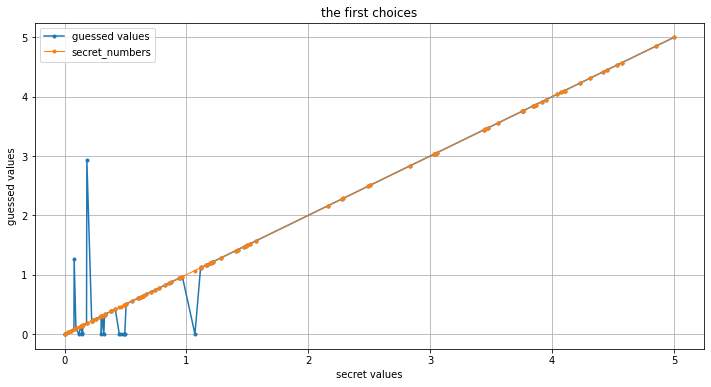

In [21]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the first choices')
ax.grid(True)

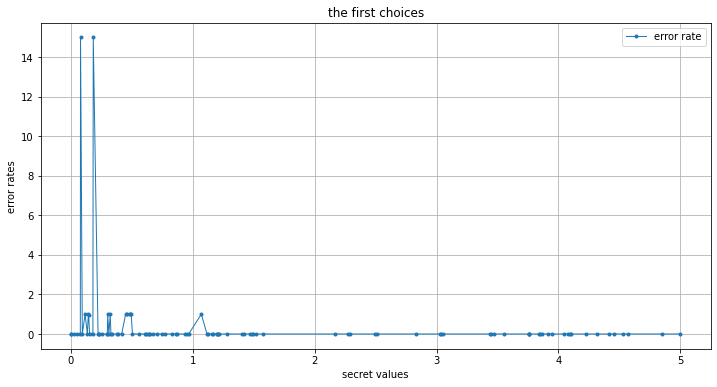

In [22]:
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the first choices')
ax.grid(True)

### Graphs of the second choice

In [23]:
pprint('The total number of the second choices is: %d' % (multiple_results.groupby(SECRET_VALUE).size().prod()-1))

'The total number of the second choices is: 1178643571979107376'


In [24]:
guess_values = ((multiple_results[LOW_VALUE] + multiple_results[HIGH_VALUE]) / 2.0)
error_rate = ((guess_values - multiple_results[SECRET_VALUE])/multiple_results[SECRET_VALUE]).abs()
second_choice_results = multiple_results.loc[error_rate.groupby(multiple_results[SECRET_VALUE]).idxmin()]
guess_values = ((second_choice_results[LOW_VALUE] + second_choice_results[HIGH_VALUE]) / 2.0)
guess_values.index = second_choice_results[SECRET_VALUE]
guess_values.sort_index(inplace=True)

error_rate = ((guess_values - guess_values.index)/guess_values.index).abs()
(error_rate < 1e-3).value_counts()

True     98
False     2
dtype: int64

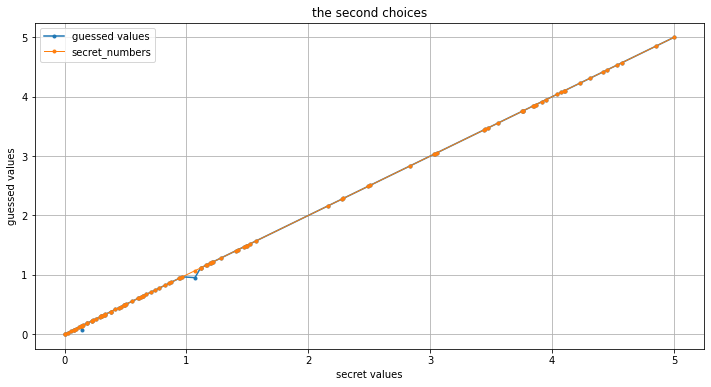

In [25]:
ax = guess_values.plot(figsize = (12, 6), marker='.', label='guessed values')
ax.plot(guess_values.index, guess_values.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.set_title('the second choices')
ax.grid(True)

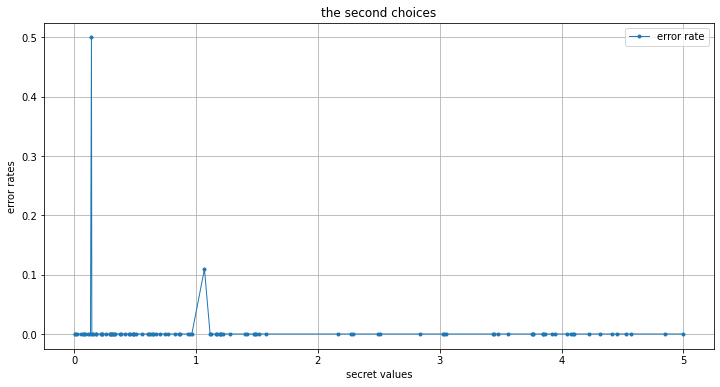

In [26]:
ax = error_rate.plot(figsize = (12, 6), label='error rate', marker='.', linewidth=1)
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.set_title('the second choices')
ax.grid(True)

# Batina method

In [58]:
def batina_guess_number(secret_number, guess_range, precision, known_inputs):
    low, high = guess_range
    guess_val = np.arange(low, high, precision)
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    hw['actual'] = np.vectorize(hamming_weight)(known_inputs * secret_number)
    corr = hw.corr(method='pearson')['actual'].drop('actual')
    idxmax = corr.idxmax()
    return idxmax, corr[idxmax]

In [48]:
batinta_results = pd.Series(name='guessed_numbers', dtype=np.float32)

In [49]:
# we have to define a low precision, otherwise, it takes too long time to run
precision = 1e-3
known_inputs = np.random.uniform(-1e1, 1e1, 1000)

In [59]:
%%time
for idx in secret_numbers:
    if idx in batinta_results.index:
        continue    
    batinta_results[idx], corr = batina_guess_number(idx, guess_range, precision, known_inputs)
    print('secret_value = %f, guessed_value = %f, corr=%f' % (idx, batinta_results[idx], corr))
batinta_results.sort_index(inplace=True)    

secret_value = 4.998062, guessed_value = 4.998000, corr=0.594267
secret_value = 4.074585, guessed_value = 4.075000, corr=0.554211
secret_value = 1.123274, guessed_value = 1.123000, corr=0.562586
secret_value = 2.165241, guessed_value = 2.165000, corr=0.529056
secret_value = 3.761680, guessed_value = 3.762000, corr=0.566594
secret_value = 0.604807, guessed_value = 0.605000, corr=0.675364
secret_value = 3.053695, guessed_value = 3.053000, corr=0.490245
secret_value = 0.145841, guessed_value = 4.667000, corr=0.383242
secret_value = 2.507702, guessed_value = 2.508000, corr=0.558658
secret_value = 4.314664, guessed_value = 4.315000, corr=0.492380
secret_value = 4.043495, guessed_value = 4.044000, corr=0.541411
secret_value = 0.227009, guessed_value = 0.227000, corr=0.750783
secret_value = 0.142557, guessed_value = 2.281000, corr=0.374631
secret_value = 0.231385, guessed_value = 0.231000, corr=0.635661
secret_value = 4.453454, guessed_value = 4.454000, corr=0.566735
secret_value = 1.218299, 

### Save data

In [60]:
from datetime import datetime
batinta_results_fname = 'batinta_results-%s_%s.csv' % (datetime.now().strftime("%Y%m%d"), secret_signature(secret_numbers).decode('utf8'))
batinta_results.to_csv(batinta_results_fname)
pprint('batinta_results_fname = %s' % batinta_results_fname)

'batinta_results_fname = batinta_results-20200602_bcd4.csv'


### Load data

In [61]:
# batinta_results_fname = 'batinta_results-%s.csv' % '20200522_071337'
batinta_results = pd.read_csv(batinta_results_fname, index_col=0, squeeze=True)
batinta_results.sort_index(inplace=True)    
batinta_results

0.003662    3.750
0.004131    4.230
0.025044    0.401
0.053237    3.407
0.077023    4.930
            ...  
4.453454    4.454
4.531985    4.532
4.571101    4.571
4.848956    4.849
4.998062    4.998
Name: guessed_numbers, Length: 100, dtype: float64

### Graphs

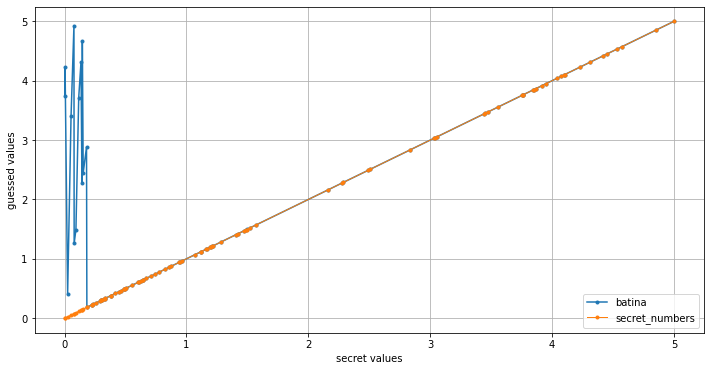

In [62]:
ax = batinta_results.plot(figsize = (12, 6), marker='.', label='batina')
#results.plot(ax=ax, marker='.', label='bxlab')
ax.plot(batinta_results.index, batinta_results.index, marker='.', linewidth=1, label='secret_numbers')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('guessed values')
ax.grid(True)

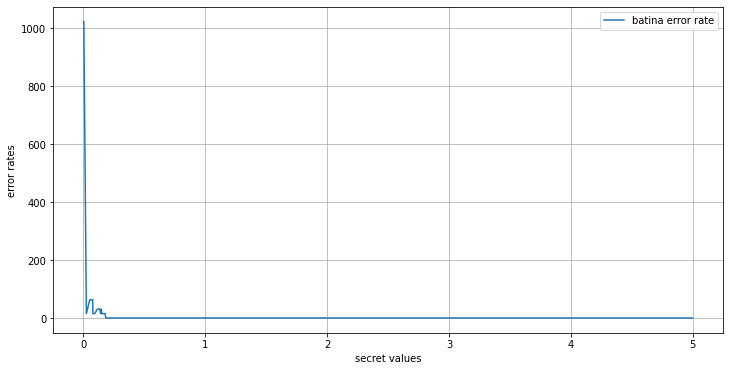

In [63]:
batina_error_rate = ((batinta_results - batinta_results.index)/batinta_results.index).abs()
ax = batina_error_rate.plot(figsize = (12, 6), label='batina error rate')
#ax = error_rate.plot(ax=ax, label='error rate')
ax.legend()
ax.set_xlabel('secret values')
ax.set_ylabel('error rates')
ax.grid(True)

In [64]:
batina_error_rate[batina_error_rate > 0.10]

0.003662    1022.982537
0.004131    1022.963081
0.025044      15.011634
0.053237      62.996942
0.077023      63.007152
0.078687      15.000132
0.093236      15.002342
0.116138      31.004928
0.134652      31.000938
0.142557      15.000587
0.145841      31.000567
0.152828      15.004932
0.180191      14.999655
dtype: float64

In [65]:
####
# number of correctly guessed values / number of wrong values
###
(batina_error_rate < precision).value_counts()

True     80
False    20
dtype: int64

# Annex

In [ ]:
def annex_compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-5))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [ ]:
guess_range=(-3e0, 3e0)
# the number of guess values in the guess range
guess_val_size=4000
# generate the known inputs which is used to test the guess values
known_inputs = np.random.uniform(-1e2, 1e2, 1000)

secret_number = random.uniform(guess_range[0], guess_range[1]) 
secret_number = 6.374345698e-2
print('secret_number =', secret_number)

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = annex_compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = annex_compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = annex_compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    
plt.show()